In [1]:
#Imports
import numpy as np
from skimage.measure import label, regionprops, find_contours, LineModelND, ransac
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 
#Find homography
source_pts = np.array([[100, 90], [475, 70], [425, 370], [75, 470]], dtype = 'float32') #pixels!
dst_pts = np.array([[0, 0], [100, 0], [80, 80], [0, 100]], dtype = 'float32') #cm

homography_matrix, _ = cv2.findHomography(source_pts, dst_pts, cv2.RANSAC, 5.0) #not sure what the 5.0 is really doing seems to work though
POINTMOO = np.array([[75,470]],dtype = 'float32')
POINTMOO = np.array([POINTMOO])
dst_pt = cv2.perspectiveTransform(POINTMOO, homography_matrix)
#print(dst_pt[0][0][0])
#print(dst_pt[0][0][1])
#print(dst_pt)
#Locations of objects and distance thresholds (how close does the rat have to be to be near it)
familiarObject_center_x = 380
familiarObject_center_y = 160
realWorld_famObj_center = cv2.perspectiveTransform(np.array([np.array([[familiarObject_center_x,familiarObject_center_y]], dtype='float32')]), homography_matrix)
familiarObject_center_x_realWorld = realWorld_famObj_center[0][0][0]
familiarObject_center_y_realWorld = realWorld_famObj_center[0][0][1]
DistanceThreshold_familiarObject = 22;
numFrames_FamiliarObject = 0;

novelObject_center_x = 210
novelObject_center_y = 320
realWorld_novelObj_center = cv2.perspectiveTransform(np.array([np.array([[novelObject_center_x,novelObject_center_y]],dtype='float32')]), homography_matrix)
novelObject_center_x_realWorld = realWorld_novelObj_center[0][0][0]
novelObject_center_y_realWorld = realWorld_novelObj_center[0][0][1]
DistanceThrehshold_NovelObject = 22;
numFrames_NovelObject = 0;

#setup for background model and foreground tracking
if 'fgbg' not in locals():
    fgbg = cv2.createBackgroundSubtractorKNN()
    
morph_size = 2
shadowValue = 127
learnBG = False
showShadow = False

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))

# Actual Work Happens Below

input video file length is 697.2333333333333 seconds
input video file has a framerate of 30.0 fps
shadows ON
shadows OFF
background learning ON
background learning OFF
Total amount of time spent with objects: 33.333333333333336 seconds
Percentage of time spent with objects that was spent with the novel object: 91.89999999999999%
exited gracefully


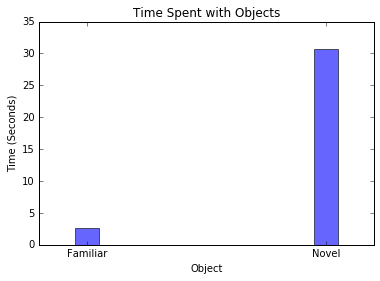

In [2]:
#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader('Round2/Day3/Test-2-cropped.mkv')
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
    
        ratBlob = regions[largestBlobIndex]
        
        #print(ratBlob.perimeter)
        #ratContours = find_contours(fgmask,0.8)
        #print(ratContours)
        #ratContours = np.asarray(ratContours).reshape(-1,1,2).astype(np.int32)
        #print(ratContours)
        #cv2.drawContours(im, ratContours,0,(0,255,0),2)
        #cv2.putText(im, str(ratContours[0][0]), (30,30), cv2.FONT_HERSHEY_PLAIN,2,255)
        
        y0, x0 = ratBlob.centroid
        
#MOOO
        #Contour and line of best fit
#         _, contours, _ = cv2.findContours(fgmask,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#         #print(contours[0])
#         #print(ratContours)
#         rows, cols = im.shape[:2]
#         [vx,vy,x,y] = cv2.fitLine(contours[0], cv2.DIST_L2,0,0.01,0.01)
#         lefty = int((-x*vy/vx) + y)
#         righty = int(((cols-x)*vy/vx) + y)
#         cv2.drawContours(im, contours, 0,(0,255,0),2)
#         cv2.arrowedLine(im,(cols-1,righty),(0,lefty),(255,0,0),2)

        #draw tracking "dot"
        cv2.circle(im,(int(x0),int(y0)),10,(255,255,255),-11)
        cv2.circle(im,(int(x0),int(y0)),11,(0,0,255),1) # draw circle
        cv2.ellipse(im, (int(x0),int(y0)), (10,10), 0, 0, 90,(0,0,255),-1 )
        cv2.ellipse(im, (int(x0),int(y0)), (10,10), 0, 180, 270,(0,0,255),-1 )
        cv2.circle(im,(int(x0),int(y0)),1,(0,255,0),1) # draw center
        #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))
        
        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 
        
        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 
        
        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[x0,y0]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]
        
        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 
            
        
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('im',im)
    cv2.imshow('bg',bg)
    
    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

# Tracker!

In [4]:
#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader('Round2/Day3/Test-2-cropped.mkv')
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
    
        ratBlob = regions[largestBlobIndex]
        
        #print(ratBlob.perimeter)
        #ratContours = find_contours(fgmask,0.8)
        #print(ratContours)
        #ratContours = np.asarray(ratContours).reshape(-1,1,2).astype(np.int32)
        #print(ratContours)
        #cv2.drawContours(im, ratContours,0,(0,255,0),2)
        #cv2.putText(im, str(ratContours[0][0]), (30,30), cv2.FONT_HERSHEY_PLAIN,2,255)
        
        y0, x0 = ratBlob.centroid
                
        #generate coordinates of line
        minr, minc, maxr, maxc = ratBlob.bbox
        width = (maxc - minc) + 1
        height = (maxr - minr) + 1
        slope = (height / width)
        for x in range(0, width):
            y = (slope * (x - x0)) + y0
        
        data = ratBlob.coords
        
#         rows,cols = im.shape[:2]
#         [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
#         lefty = int((-x*vy/vx) + y)
#         righty = int(((cols-x)*vy/vx)+y)
#         cv2.line(im,(cols-1,righty),(0,lefty),(0,255,0),2)
        
        #fit line using all data
        model = LineModelND()
        model.estimate(data)
        
        #robustly fit line only using inlier data with RANSAC algorithm
        model_robust, inliers = ransac(data, LineModelND, min_samples = 2, residual_threshold = 1, max_trials = 1000)
        outliers = inliers == False
        
        #generate coordinates of estimated models
        line_x = np.arange(0, width)
        line_y = model.predict_y(line_x)
        line_y_robust = model_robust.predict_y(line_x)
                
#         fig, ax = plt.subplots()
#         #ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha = 0.6, label = 'Inlier data')
#         #ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha = 0.6, label = 'Outlier data')
#         ax.plot(line_x, line_y, '-k', label = 'Line model from all data')
#         #ax.plot(line_x, line_y_robust, '-b', label = 'Robust line model')
#         ax.legend (loc = 'lower left')
#         plt.show()
#MOOO
        #Contour and line of best fit
#         _, contours, _ = cv2.findContours(fgmask,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#         #print(contours[0])
#         #print(ratContours)
#         rows, cols = im.shape[:2]
#         [vx,vy,x,y] = cv2.fitLine(contours[0], cv2.DIST_L2,0,0.01,0.01)
#         lefty = int((-x*vy/vx) + y)
#         righty = int(((cols-x)*vy/vx) + y)
#         cv2.drawContours(im, contours, 0,(0,255,0),2)
#         cv2.arrowedLine(im,(cols-1,righty),(0,lefty),(255,0,0),2)

        #draw tracking "dot"
        cv2.circle(im,(int(x0),int(y0)),10,(255,255,255),-11)
        cv2.circle(im,(int(x0),int(y0)),11,(0,0,255),1) # draw circle
        cv2.ellipse(im, (int(x0),int(y0)), (10,10), 0, 0, 90,(0,0,255),-1 )
        cv2.ellipse(im, (int(x0),int(y0)), (10,10), 0, 180, 270,(0,0,255),-1 )
        cv2.circle(im,(int(x0),int(y0)),1,(0,255,0),1) # draw center
        #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))
        
        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 
        
        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 
        
        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[x0,y0]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]
        
        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 
            
        
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('im',im)
    cv2.imshow('bg',bg)
    
    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

input video file length is 697.2333333333333 seconds
input video file has a framerate of 30.0 fps


TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind''

In [ ]:
line_y.shape

In [ ]:
#Imports
import numpy as np
from skimage.measure import label, regionprops, find_contours, LineModelND, ransac
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 

#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader('Round2/Day3/Test-2-cropped.mkv')
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
    
        ratBlob = regions[largestBlobIndex]
        
        #print(ratBlob.perimeter)
        #ratContours = find_contours(fgmask,0.8)
        #print(ratContours)
        #ratContours = np.asarray(ratContours).reshape(-1,1,2).astype(np.int32)
        #print(ratContours)
        #cv2.drawContours(im, ratContours,0,(0,255,0),2)
        #cv2.putText(im, str(ratContours[0][0]), (30,30), cv2.FONT_HERSHEY_PLAIN,2,255)
        
        y0, x0 = ratBlob.centroid
                
        #generate coordinates of line
        minr, minc, maxr, maxc = ratBlob.bbox
        width = (maxc - minc) + 1
        height = (maxr - minr) + 1
        slope = (height / width)
        for x in range(0, width):
            y = (slope * (x - x0)) + y0
        
        data = ratBlob.coords
        
        #fit line using all data
        model = LineModelND()
        model.estimate(data)
        
        #robustly fit line only using inlier data with RANSAC algorithm
        #model_robust, inliers = ransac(data, LineModelND, min_samples = 2, residual_threshold = 1, max_trials = 1000)
        #outliers = inliers == False
        
        #generate coordinates of estimated models
        line_x = np.arange(0, width)
        line_y = model.predict_y(line_x)
        #line_y_robust = model_robust.predict_y(line_x)
        
        fig, ax = plt.subplots()
        #ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha = 0.6, label = 'Inlier data')
        #ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha = 0.6, label = 'Outlier data')
        ax.plot(line_x, line_y, '-k', label = 'Line model from all data')
        #ax.plot(line_x, line_y_robust, '-b', label = 'Robust line model')
        ax.legend (loc = 'lower left')
        plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.measure import LineModelND, ransac


np.random.seed(seed=1)

# generate coordinates of line
x = np.arange(-200, 200)
y = 0.2 * x + 20
data = np.column_stack([x, y])

# add faulty data
faulty = np.array(30 * [(180., -100)])
faulty += 5 * np.random.normal(size=faulty.shape)
data[:faulty.shape[0]] = faulty

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape)
data += 0.5 * noise
data[::2] += 5 * noise[::2]
data[::4] += 20 * noise[::4]

# fit line using all data
model = LineModelND()
model.estimate(data)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                               residual_threshold=1, max_trials=1000)
outliers = inliers == False

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
        label='Inlier data')
ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6,
        label='Outlier data')
ax.plot(line_x, line_y, '-k', label='Line model from all data')
ax.plot(line_x, line_y_robust, '-b', label='Robust line model')
ax.legend(loc='lower left')
plt.show()

In [ ]:
data.shape